# TP3 - Market Basket Analysis 
INF8111 - Fouille de données (Data Mining), Summer 2019 - Prof. Daniel Aloise
### Team Components
    - Emilio Rivera (1689355)
    - Olivia Gelinas (1784417)

**Authors**: Rodrigo Randel & Daniel Aloise

## Market Basket Analysis

Market Basket Analysis (MBA) is a data mining analytics technique to uncover associations between products or product grouping. By exploring interesting patterns from an extensive collection of data, MBA aims to understand/reveal customer purchase behaviors based upon the theory that if you purchased a certain set of products, then you are more (or less) likely to buy another group of products. In other words, MBA allows retailers to identify the relationship between the items that customers buy, revealing patterns of items often purchased together.

A widely approach to explore these patterns is by constructing ***association rules*** such as:
- **if** bought *ITEM_1* **then** will buy *ITEM_2* with **confidence** *X*.

These associations do not have to be 1-to-1 rules. They can involve many items. For example, a person in a supermarket may add eggs to his/her cart, then an MBA application may suggest that the person will also buy some bread and/or flour: 
    
+ **if** bought *EGGS* **then** will buy [*BREAD* with confidence *0.2*; *FLOUR* with confidence 0.05].

However, if the person now decides to add flour to his/her cart, the new association rule could be as showing below, suggesting ingredients to make a cake.

+ **if** bought [*EGGS, FLOUR*] **then** will buy [*SUGGAR* with confidence 0.45; BAKING POWDER with confidence 0.12; *BREAD* with confidence *0.03*].


There are many real scenarios where MBA plays a central role in data analysis, such as supermarket transactions, online orders or credit card history. Marketers may use these association rules to allocate correlated products close to each other on store shelves or make online suggestions so that customers buy more items. Some questions that an MBA can usually help retailers to answer are:

    - What items are often purchased together?
    - Given a basket, what items should be suggested?
    - How should items be placed together on the shelves?


### Objective

Your goal in this TP is to develop an MBA algorithm for revealing patterns by creating association rules in a big dataset with more than three millions supermarket transactions. However, mining association rules for large datasets is a very computationally intensive problem, which makes it almost impractical to perform it without a distributed system. Hence, to run your algorithm, you will have access to a distributed cloud computing cluster with hundreds of cores. 

To this end, a **MapReduce** algorithm will be implemented upon the [Apache Spark](http://spark.apache.org) framework, a fast cluster computing system. In a nutshell, Spark is an open source framework designed with a *scale-out* methodology which makes it a very powerful tool for programmers or application developers to perform a massive volume of computations and data processing in distributed environments. Sparks provides high-level APIs that make it easy to build parallel apps without needing to worry about how your code and data are parallelized/distributed thought the computing cluster. Spark does it all for you.
 
The implementation will follow the Market Basket Analysis algorithm presented by Jongwook Woo and Yuhang Xu (2012). The image **workflow.svg** Illustrates the algorithm's workflow, and is to be used for consultation throughout this TP. The blue boxes are the ones where you must implement a method to perform a map or reduce function, and the grey boxes represent their expected output. **All these operations are explained in details in the following sections.** 

<!---
# ![scale=0.5](workflow.svg "Algorithm Workflow")
-->

## 1. Setting up Spark

Spark runs on both Windows and UNIX-like systems (e.g., Linux, Mac OS). It's easy to run locally on one machine — all you need is to have Java installed on your system PATH, or the JAVA_HOME environment variable pointing to a Java installation. It is recommended that you have the **JDK v8** installed in your system. If you haven't, go to [Java's web page](https://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) to download and install a Java Virtual Machine. Remember to set the environment variable JAVA_HOME if your installation does not do it automatically for you. 

The interface between Python and Spark is done through **PySpark**, which can be installed with *pip* as demonstrated below.

The first task is to get Spark up and running. 
1. First, go to http://spark.apache.org/downloads 
2. Select the newest Spark release and the pre-built package type
3. Click for download **spark-2.4.3-bin-hadoop2.7.tgz** and unzip it in any folder of your preference. 
4. Next, export the following variables to link PYSPARK (Spark's python interface) to your python distribution
    - export SPARK_HOME=/Users/rodrigorandel/Downloads/spark-2.4.3-bin-hadoop2.7
    - export PYTHONPATH=$PYTHONPATH:$SPARK_HOME/python:$SPARK_HOME/python/lib/py4j-0.10.7-src.zip:$SPARK_HOME/python/lib/pyspark.zip

In [2]:
# ! pip install pyspark# 

### 1.1 Product Counting Example 

To test your installation and start to get familiarized with Spark, we will follow an example that counts how many times the products of a toy dataset were purchased.

The main entry point to start programming with Spark is the [RDD API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD), an excellent Spark abstraction to work with the MapReduce framework.  RDD is a collection of elements partitioned across the nodes of the cluster that can operate in parallel. In other words, RDD is how Spark keeps your data ready to perform some function (e.g., a map or reduce function) in parallel. **Do not worry if this still sounds confusing, it will be clear once you start implementing**. However, it is part of this TP to study/consult the [Spark python API](https://spark.apache.org/docs/latest/api/python/) and learn how to use it. Some useful functions that the RDD API offers are:

1. **map**: return a new RDD by applying a function to each element of this RDD.
2. **flatMap**: return a new RDD by first applying a function to all elements of this RDD, and then flattening the results. **Should be used when each entry will yield more than one mapped element**
3. **reduce**: reduces the elements of this RDD using the specified commutative and associative binary operator.
4. **reduceByKey**: merge the values for each key using an associative and commutative reduce function
5. **groupByKey**: group the values for each key in the RDD into a single sequence
6. **collect**: return a list that contains all of the elements in this RDD. **Should not be used when working with a lot of data**
7. **sample**: return a sampled subset of this RDD
8. **count**: return the number of elements in this RDD.
9. **filter**: return a new RDD containing only the elements that satisfy a predicate.

In [1]:
GPC = True
TOY_DATASET_PATH = 'gs://inf8111bucket/instacart/toy.csv' if GPC else './toy.csv'
INSTA_ORDER_PRODUCTS_TRAIN_PATH = 'gs://inf8111bucket/instacart/order_products__train.csv' if GPC else 'instacart/order_products__train.csv'

INSTA_ORDERS_PATH = 'gs://inf8111bucket/instacart/orders.csv' if GPC else 'instacart/orders.csv'
INSTA_PRODUCTS_PATH = 'gs://inf8111bucket/instacart/products.csv' if GPC else 'instacart/products.csv'
INSTA_ORDER_PRODUCTS_PRIOR_PATH = 'gs://inf8111bucket/instacart/order_products__prior.csv' if GPC else 'instacart/order_products__prior.csv'


In [2]:
from pyspark.sql import SparkSession

def map_to_product(row):
    """
    Map each transaction into a set of KEY-VALUE elements.
    The KEY is the word (product) itself and the VALUE is its number of apparitions.
    """
    products = row.transaction.split(';') # split products from the column transaction
    for p in products:
        yield (p, 1)

def reduce_product_by_key(value1, value2):
    "Reduce the mapped objects to unique words by merging (summing ) their values"
    return value1+value2

# Initializates a object of SparkSession class, main entry point to Spark's funcionalites
spark = SparkSession.builder.getOrCreate()
        
# Read a toy dataset
toy = spark.read.csv(TOY_DATASET_PATH, header=True, inferSchema=True, encoding='utf8', )
print("Toy dataset")
toy.show()

# Obtain a RDD object to call a map function
toy_rdd = toy.rdd
print("Toy dataframe as a RDD object (list of Row objects):\n\t", toy_rdd.collect())

# Map function to identify all products
toy_rdd = toy_rdd.flatMap(map_to_product)
print("\nMapped products:\n\t", toy_rdd.collect())

# Reduce function to merge values of elements that share the same KEY
toy_rdd = toy_rdd.reduceByKey(reduce_product_by_key)
print("\nReduced (merged) products:\n\t", toy_rdd.collect())

print("\nVisualizing as a dataframe:")
toy_rdd.toDF(["product", "count_product"]).show()

Toy dataset
+--------+-----------+
|order_id|transaction|
+--------+-----------+
|       1|      a;b;c|
|       2|      a;b;d|
|       3|        b;c|
|       4|        b;c|
+--------+-----------+

('Toy dataframe as a RDD object (list of Row objects):\n\t', [Row(order_id=1, transaction=u'a;b;c'), Row(order_id=2, transaction=u'a;b;d'), Row(order_id=3, transaction=u'b;c'), Row(order_id=4, transaction=u'b;c')])
('\nMapped products:\n\t', [(u'a', 1), (u'b', 1), (u'c', 1), (u'a', 1), (u'b', 1), (u'd', 1), (u'b', 1), (u'c', 1), (u'b', 1), (u'c', 1)])
('\nReduced (merged) products:\n\t', [(u'a', 2), (u'c', 3), (u'b', 4), (u'd', 1)])

Visualizing as a dataframe:
+-------+-------------+
|product|count_product|
+-------+-------------+
|      a|            2|
|      c|            3|
|      b|            4|
|      d|            1|
+-------+-------------+



### 1.2 Working the Spark's Dataframe

In the example above, we briefly used a Spark's Dataframe class, but only to obtain an RDD object with ```toy.rdd``` and to print the data as a structured table with the ```show()``` function. However, [Dataframe](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#) is a big part of the current Spark release and is built upon the RDD API. It is a distributed collection of rows under named columns, the same as a table in a relational database. Spark's Dataframe works similarily as [Pandas'](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). In fact, we can export (obtain) a Spark's data frame to (from) a pandas' data frame with the function ```toPandas()``` (```spark.createDataFrame```).

A central functionality of the data frame is to profit from the [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), a module that allows SQL queries over structured data. For example, the same 'product counting example' could have been implemented as a sequence of SQL operations over the data:  

In [3]:
import pyspark.sql.functions as f

In [21]:
# Creates a new column, products, with all products appering in each transaction
print('New column \'products\': exploding the transaction\'s products to a new row')
df_toy = toy.withColumn('products', f.explode(f.split(toy.transaction, ';')))
df_toy.show()

# Performs a select query and group rows by the product name, aggreagating by counting
print('Couting unique products:')
df_toy.select(df_toy.products)\
      .groupBy(df_toy.products)\
      .agg(f.count('products').alias('count_product'))\
      .sort('count_product', ascending=False)\
      .show()

New column 'products': exploding the transaction's products to a new row
+--------+-----------+--------+
|order_id|transaction|products|
+--------+-----------+--------+
|       1|      a;b;c|       a|
|       1|      a;b;c|       b|
|       1|      a;b;c|       c|
|       2|      a;b;d|       a|
|       2|      a;b;d|       b|
|       2|      a;b;d|       d|
|       3|        b;c|       b|
|       3|        b;c|       c|
|       4|        b;c|       b|
|       4|        b;c|       c|
+--------+-----------+--------+

Couting unique products:
+--------+-------------+
|products|count_product|
+--------+-------------+
|       b|            4|
|       c|            3|
|       a|            2|
|       d|            1|
+--------+-------------+



Also, the same SQL operations performed above could have been done with a traditional SQL language query as showing below:

In [22]:
# Creates a relational table TOY in the Spark session
df_toy.createOrReplaceTempView("TOY")

spark.sql("SELECT t.products, COUNT(t.products) AS product_count"
          " FROM TOY t"
          " GROUP BY t.products"
          " ORDER BY product_count DESC").show()

+--------+-------------+
|products|product_count|
+--------+-------------+
|       b|            4|
|       c|            3|
|       a|            2|
|       d|            1|
+--------+-------------+



These SQL concepts are being mentioned here because they will be useful to us during the TP, mainly in Section 3, to manipulate the supermarket data, which is structured in data frames. Then, if you are not familiar with SQL, it is recommended that you follow a [tutorial](https://www.w3schools.com/sql/) to understand the basics.

## 2. MBA Algorithm 
 The following sections explain how you should develop each step of the MapReduce algorithm for our supermarket application. Figure workflow.png illustrates each step of the algorithm.
 
### 2.1 Map to Patterns (10 points)
For a given a set of transactions (i.e., the rows of our toy dataset), each transaction must be **mapped** into a set of *purchase patterns* found within the transaction. Formally, these patterns are subsets of products that represent a group of items bought together. 
    
For the MapReduce framework, each pattern must be created as a *KEY-VALUE* element, where they KEY can take the form of a singleton, a pair or a trio of products that are present in the transaction. More precisely, for each transaction, the mapping function must generate all possible **unique** subsets of size ONE, TWO or THREE.  The VALUE associated with each KEY is the number of times that the KEY appeared in the transaction (if we assume that no product appears more than once in the transaction, this value is always equal to one). 

Now, implement the  **map_to_patterns** function that receives a transaction (a row from the data frame) and returns the patterns found in the transaction. The mapped elements are a tuple (KEY, VALUE), where KEY is also a tuple of product names. It is crucial to notice that, since each entry (transaction) of the map function will **yield** more than one KEY-VALUE element, a *flatMap* must be invoked for this step.

For the toy dataset, the expected output is similar to:

<pre style="align:center; border:1px solid black;font-size: 9pt; line-height: 1.1; height: auto; width: 18em; padding-left:5px">
<code>
+---------------+-----------+
|       patterns|occurrences|
+---------------+-----------+
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'c')|          1|
|     ('a', 'c')|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'd')|          1|
|     ('a', 'd')|          1|
|         ('b',)|          1|
|     ('b', 'd')|          1|
|         ('d',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
+---------------+-----------+
</code>
</pre>

In [4]:
def get_all_patterns_non_consecutive(string):
    string_alphabet = set(chars)
    for subset_len in [1,2,3]:
        for c in itertools.combinations(string_alphabet, subset_len):
            yield c

In [5]:
def format_tuples(pattern):
    """
    Used for visualizition.
    Transforms tuples to a string since Dataframe does not support column of tuples with different sizes
    (a,b,c) -> '(a,b,c)'
    """
    return (str(pattern[0]), str(pattern[1]))
import itertools
ALLOW_DUPS = True
def map_to_patterns(row):
    """
    TODO
    """
    chars = row.transaction.split(';')
    already_yielded = set()
    for subset_len in [1,2,3]:
        for c in itertools.combinations(chars, subset_len):
            if ALLOW_DUPS:
                k = tuple(sorted(c))
            else:
                k = tuple(sorted(set(c)))
            if k not in already_yielded:
                already_yielded.add(k)
                yield k, 1
def map_to_patterns_no_split(row):
    chars = row.transaction
    already_yielded = set()
    for subset_len in [1,2,3]:
        for c in itertools.combinations(chars, subset_len):
            if ALLOW_DUPS:
                k = tuple(sorted(c))
            else:
                k = tuple(sorted(set(c)))
            if k not in already_yielded:
                already_yielded.add(k)
                yield k, 1
toy_rdd = toy.rdd
patterns_rdd = toy_rdd.flatMap(map_to_patterns)

# Output as dataframe
patterns_rdd.map(format_tuples).toDF(['patterns', 'occurrences']).show()

+------------------+-----------+
|          patterns|occurrences|
+------------------+-----------+
|           (u'a',)|          1|
|           (u'b',)|          1|
|           (u'c',)|          1|
|      (u'a', u'b')|          1|
|      (u'a', u'c')|          1|
|      (u'b', u'c')|          1|
|(u'a', u'b', u'c')|          1|
|           (u'a',)|          1|
|           (u'b',)|          1|
|           (u'd',)|          1|
|      (u'a', u'b')|          1|
|      (u'a', u'd')|          1|
|      (u'b', u'd')|          1|
|(u'a', u'b', u'd')|          1|
|           (u'b',)|          1|
|           (u'c',)|          1|
|      (u'b', u'c')|          1|
|           (u'b',)|          1|
|           (u'c',)|          1|
|      (u'b', u'c')|          1|
+------------------+-----------+



### 2.2 Reduce patterns (5 points)
Once different CPUs processed the transactions, a **reduce** function must take place to combine identical KEYS (the subset of products) and compute the total number of its occurrences in the entire dataset. In other words, this reduce procedure must sum the *VALUE* of each identical KEY.

Create a **reduce_patterns** function below that must sum the VALUE of each pattern.
For the toy dataset, the expected output is:
<pre style="align:center; border:1px solid black;font-size: 9pt; line-height: 1.1; height: auto; width: 24em; padding-left:5px">
<code>
+---------------+--------------------+
|       patterns|combined_occurrences|
+---------------+--------------------+
|         ('a',)|                   2|
|     ('a', 'b')|                   2|
|('a', 'b', 'c')|                   1|
|     ('a', 'c')|                   1|
|         ('b',)|                   4|
|     ('b', 'c')|                   3|
|         ('c',)|                   3|
|('a', 'b', 'd')|                   1|
|     ('a', 'd')|                   1|
|     ('b', 'd')|                   1|
|         ('d',)|                   1|
+---------------+--------------------+
</code>
</pre>


In [6]:
"""
TODO
"""
combined_patterns_rdd = patterns_rdd.groupByKey().mapValues(sum)
# or...
# from operator import add
# combined_patterns_rdd = patterns_rdd.reduceByKey(add)
# or ...
def reduce_patterns(c, row):
    return c + row
combined_patterns_rdd = patterns_rdd.reduceByKey(reduce_patterns)
# Output as dataframe
combined_patterns_rdd.map(format_tuples).toDF(['patterns', 'combined_occurrences']).show()

+------------------+--------------------+
|          patterns|combined_occurrences|
+------------------+--------------------+
|      (u'b', u'c')|                   3|
|           (u'a',)|                   2|
|           (u'c',)|                   3|
|(u'a', u'b', u'd')|                   1|
|           (u'b',)|                   4|
|      (u'a', u'c')|                   1|
|           (u'd',)|                   1|
|      (u'a', u'd')|                   1|
|(u'a', u'b', u'c')|                   1|
|      (u'a', u'b')|                   2|
|      (u'b', u'd')|                   1|
+------------------+--------------------+



### 2.3 Map to subpatterns (15 points)
Next, another **map** function should be applied to generate subpatterns. Once again, the subpatterns are KEY-VALUE elements, where the KEY is a subset of products as well. However, creating the subpattern's KEY is a different procedure. This time, the idea is to break down the list of products of each pattern (pattern KEY), remove one product at a time, and yield the resulting list as the new subpattern KEY. 

For example, for a given pattern $P$ with three products, $p_1, p_2 $ and $p_3$, three new subpatterns KEYs are going to be created: (i) remove $p_1$ and yield ($p_2, p_3$); (ii) remove $p_2$ and yield ($p_1,p_3$); and (iii) remove $p_3$ and yield ($p_1,p_2$). 

Additionally, the subpattern's VALUE structure will also be different. Instead of just single integer value as we had in the patterns, this time a *tuple* should be created for the subpattern VALUE. This tuple contains the product that was removed when yielding the KEY and the number of times the pattern appeared. For the example above, the values should be ($p_1,v$), ($p_2,v$) and ($p_3,v$), respectively, where $v$ is the VALUE of the pattern. 

The idea behind subpatterns is to create **rules** such as: when the products of KEY were bought, the item present in the VALUE was also bought *v* times. Furthermore, each pattern should also yield a subpattern where the KEY is the same list of products of the pattern, but the VALUE is a tuple with a null product (None) and the number of times the pattern appeared. This element will be useful to keep track of how many times such a pattern was found and later will be used to compute the confidence value when generating the association rules. 

Now, implement the  **map_to_subpatterns** function that receives a pattern and yields all found subpatterns. Once again, each entry (pattern) will generate more than one KEY-VALUE element, then a flatMap function must be called.

For the toy dataset, the expected output is:

<pre style="align:center; border:1px solid black;font-size: 9pt; line-height: 1.1; height: auto; width: 17em; padding-left:5px">
<code>
+---------------+---------+
|    subpatterns|    rules|
+---------------+---------+
|         ('a',)|(None, 2)|
|     ('a', 'b')|(None, 2)|
|         ('b',)| ('a', 2)|
|         ('a',)| ('b', 2)|
|('a', 'b', 'c')|(None, 1)|
|     ('b', 'c')| ('a', 1)|
|     ('a', 'c')| ('b', 1)|
|     ('a', 'b')| ('c', 1)|
|     ('a', 'c')|(None, 1)|
|         ('c',)| ('a', 1)|
|         ('a',)| ('c', 1)|
|         ('b',)|(None, 4)|
|     ('b', 'c')|(None, 3)|
|         ('c',)| ('b', 3)|
|         ('b',)| ('c', 3)|
|         ('c',)|(None, 3)|
|('a', 'b', 'd')|(None, 1)|
|     ('b', 'd')| ('a', 1)|
|     ('a', 'd')| ('b', 1)|
|     ('a', 'b')| ('d', 1)|
|     ('a', 'd')|(None, 1)|
|         ('d',)| ('a', 1)|
|         ('a',)| ('d', 1)|
|     ('b', 'd')|(None, 1)|
|         ('d',)| ('b', 1)|
|         ('b',)| ('d', 1)|
|         ('d',)|(None, 1)|
+---------------+---------+
</code>
</pre>

In [7]:
from copy import deepcopy
def map_to_subpatterns(pattern):
    """
    TODO
    """
    import random
    key, old_count = pattern
    yield pattern[0], (None, old_count)
    if len(key) == 2 or len(key) == 3:
        for i, removed_char in enumerate(pattern[0]):
            mask = map(lambda ix: ix!=i, range(len(key)))
            new_key = tuple(itertools.compress(key, mask))
            yield new_key, (removed_char, old_count)

subpatterns_rdd = combined_patterns_rdd.flatMap(map_to_subpatterns)

# Output as dataframe
subpatterns_rdd.map(format_tuples).toDF(['subpatterns', 'rules']).show(100)

+------------------+---------+
|       subpatterns|    rules|
+------------------+---------+
|      (u'b', u'c')|(None, 3)|
|           (u'c',)|(u'b', 3)|
|           (u'b',)|(u'c', 3)|
|           (u'a',)|(None, 2)|
|           (u'c',)|(None, 3)|
|(u'a', u'b', u'd')|(None, 1)|
|      (u'b', u'd')|(u'a', 1)|
|      (u'a', u'd')|(u'b', 1)|
|      (u'a', u'b')|(u'd', 1)|
|           (u'b',)|(None, 4)|
|      (u'a', u'c')|(None, 1)|
|           (u'c',)|(u'a', 1)|
|           (u'a',)|(u'c', 1)|
|           (u'd',)|(None, 1)|
|      (u'a', u'd')|(None, 1)|
|           (u'd',)|(u'a', 1)|
|           (u'a',)|(u'd', 1)|
|(u'a', u'b', u'c')|(None, 1)|
|      (u'b', u'c')|(u'a', 1)|
|      (u'a', u'c')|(u'b', 1)|
|      (u'a', u'b')|(u'c', 1)|
|      (u'a', u'b')|(None, 2)|
|           (u'b',)|(u'a', 2)|
|           (u'a',)|(u'b', 2)|
|      (u'b', u'd')|(None, 1)|
|           (u'd',)|(u'b', 1)|
|           (u'b',)|(u'd', 1)|
+------------------+---------+



### 2.4 Reduce Subpatterns (5 points)
Once again, a **reduce** function will be required to group all the subpatterns by their KEY. The objective of this reducing procedure is to create a list with all the **rules** that appeared by a KEY. Hence, the expected resulting of the reduce function is also a KEY-VALUE element, where the KEY is the subpattern's KEY, and the VALUE is a group containing all the VALUEs of the subpatterns that share the same KEY.

For the toy dataset, the expected output is:

<pre style="align:center; border:1px solid black;font-size: 9pt; line-height: 1.1; height: auto; width: 32em; padding-left:5px">
<code>
+-----------+--------------------------------------+
|subpatterns|combined_rules                        |
+-----------+--------------------------------------+
|(a)        |((None, 2),('b', 2),('c', 1),('d', 1))|
|(a,b)      |((None, 2),('c', 1),('d', 1))         |
|(b)        |(('a', 2),(None, 4),('c', 3),('d', 1))|
|(a,b,c)    |((None, 1))                           |
|(b,c)      |(('a', 1),(None, 3))                  |
|(a,c)      |(('b', 1),(None, 1))                  |
|(c)        |(('a', 1),('b', 3),(None, 3))         |
|(a,b,d)    |((None, 1))                           |
|(b,d)      |(('a', 1),(None, 1))                  |
|(a,d)      |(('b', 1),(None, 1))                  |
|(d)        |(('a', 1),('b', 1),(None, 1))         |
+-----------+--------------------------------------+
</code>
</pre>


In [8]:
combined_rules = subpatterns_rdd.groupByKey().mapValues(lambda r: tuple(r))
# Output as dataframe
combined_rules.map(format_tuples).toDF(['subpatterns', 'combined_rules']).show(truncate=False)
subpatterns_rdd.groupByKey().mapValues(lambda r: tuple(r)).map(format_tuples).toDF(['subpatterns', 'combined_rules']).show(truncate=False)

+------------------+--------------------------------------------+
|subpatterns       |combined_rules                              |
+------------------+--------------------------------------------+
|(u'b', u'c')      |((None, 3), (u'a', 1))                      |
|(u'a',)           |((None, 2), (u'c', 1), (u'd', 1), (u'b', 2))|
|(u'c',)           |((u'b', 3), (None, 3), (u'a', 1))           |
|(u'a', u'b', u'd')|((None, 1),)                                |
|(u'b',)           |((u'c', 3), (None, 4), (u'a', 2), (u'd', 1))|
|(u'a', u'c')      |((None, 1), (u'b', 1))                      |
|(u'd',)           |((None, 1), (u'a', 1), (u'b', 1))           |
|(u'a', u'd')      |((u'b', 1), (None, 1))                      |
|(u'a', u'b', u'c')|((None, 1),)                                |
|(u'a', u'b')      |((u'd', 1), (u'c', 1), (None, 2))           |
|(u'b', u'd')      |((u'a', 1), (None, 1))                      |
+------------------+--------------------------------------------+

+--------

## 2.5. Map to Association Rules (15 points)
Finally, the last step of the algorithm is to create the association rules to perform the market basket analysis. The goal of this map function is to calculate the **confidence** level of buying a product, knowing that there is already a set of products in the basket. Thus, the KEY of the subpattern is the set of products placed in the basket and, for each product present in the list of rules, i.e., in the VALUE, the confidence can be calculated as:

\begin{align*}
\frac{\text{number of times the product was bought together with KEY }}{\text{number of times the KEY appeared}}
\end{align*}

For the example given in the Figure workflow, *coffee* was bought 20 times and, in 17 of them, *milk* was bought together. Then, the confidence level of buying *milk* knowing that *coffee* is in the basket is $\frac{17}{20} = 0.85$, which means that in 85% of the times the coffee was bought, milk was purchased as well.

Implement the **map_to_assoc_rules** function that calculates the confidence level for each subpattern.

For the toy dataset, the expected output is:
<pre style="align:center; border:1px solid black;font-size: 9pt; line-height: 1.1; height: auto; width: 35em; padding-left:5px">
<code>
+---------------+---------------------------------------+
|patterns       |association_rules                      |
+---------------+---------------------------------------+
|('a',)         |[('b', 1.0), ('c', 0.5), ('d', 0.5)]   |
|('a', 'b')     |[('c', 0.5), ('d', 0.5)]               |
|('b',)         |[('a', 0.5), ('c', 0.75), ('d', 0.25)] |
|('a', 'b', 'c')|[]                                     |
|('b', 'c')     |[('a', 0.3333333333333333)]            |
|('a', 'c')     |[('b', 1.0)]                           |
|('c',)         |[('a', 0.3333333333333333), ('b', 1.0)]|
|('a', 'b', 'd')|[]                                     |
|('b', 'd')     |[('a', 1.0)]                           |
|('a', 'd')     |[('b', 1.0)]                           |
|('d',)         |[('a', 1.0), ('b', 1.0)]               |
+---------------+---------------------------------------+
</code>
</pre>

In [57]:
def map_to_assoc_rules(rule):
    """
    TODO
    """
    pattern, association_rules = rule
    n = next((c for r,c in association_rules if r is None), -1) # Get the first value with key `None` or 0.
    c = []
    for associated_rule, pcount in association_rules:
        if associated_rule is not None:
            c.append((associated_rule, float(pcount)/n))
    return pattern, c
assoc_rules = combined_rules.map(map_to_assoc_rules)

# Output as dataframe
assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).show(truncate=False)

+------------------+-----------------------------------------+
|patterns          |association_rules                        |
+------------------+-----------------------------------------+
|(u'b', u'c')      |[(u'a', 0.3333333333333333)]             |
|(u'a',)           |[(u'c', 0.5), (u'd', 0.5), (u'b', 1.0)]  |
|(u'c',)           |[(u'b', 1.0), (u'a', 0.3333333333333333)]|
|(u'a', u'b', u'd')|[]                                       |
|(u'b',)           |[(u'c', 0.75), (u'a', 0.5), (u'd', 0.25)]|
|(u'a', u'c')      |[(u'b', 1.0)]                            |
|(u'd',)           |[(u'a', 1.0), (u'b', 1.0)]               |
|(u'a', u'd')      |[(u'b', 1.0)]                            |
|(u'a', u'b', u'c')|[]                                       |
|(u'a', u'b')      |[(u'd', 0.5), (u'c', 0.5)]               |
|(u'b', u'd')      |[(u'a', 1.0)]                            |
+------------------+-----------------------------------------+



In [56]:
1 / 5

0

## 3. Instacart dataset

With your MBA algorithm ready to be used, now it is time to work on the real dataset. For this part of the TP, download the [instacart](https://www.instacart.com/datasets/grocery-shopping-2017) dataset and read its [description](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b) to understand how the dataset is structured. 

Before applying the developed algorithm on the instacart dataset, you must first filter the transactions to be in the same format defined by your algorithm (one transaction per row). To manipulate the data, we can use Spark's data frame and the SQL module presented in Section 1.

The following code cell uses the Spark SQL module to read the orders from the ``order_products__train.csv`` and the detailed information from ``orders.csv`` and ``products.csv`` to construct a data frame that contains a list of all products ever purchased by each user.

In [10]:
df_order_prod = spark.read.csv(INSTA_ORDER_PRODUCTS_TRAIN_PATH, header=True, sep=',', inferSchema=True)
print('order_products__train.csv')
df_order_prod.show(5)

df_orders = spark.read.csv(INSTA_ORDERS_PATH, header=True, sep=',', inferSchema=True)
print('orders.csv')
df_orders.show(5)

df_products = spark.read.csv(INSTA_PRODUCTS_PATH, header=True, sep=',', inferSchema=True)
print('products.csv')
df_products.show(5)


"""
List of products ever purchased by each user
"""
# USING SQL
df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'
df_orders.createOrReplaceTempView("orders") # creates table 'orders'
df_products.createOrReplaceTempView("products") # creates table 'products'
spark.sql('SELECT o.user_id, COLLECT_LIST(p.product_name) AS products' 
               ' FROM orders o '
               ' INNER JOIN order_prod op ON op.order_id = o.order_id'
               ' INNER JOIN products p    ON op.product_id = p.product_id'
               ' GROUP BY user_id ORDER BY o.user_id').show(5, truncate=-1)


# USING DATAFRAME OPERATIONS
# df_orders.join(df_order_prod, df_order_prod.order_id == df_orders.order_id, 'inner')\
# .join(df_products, df_products.product_id == df_order_prod.product_id, 'inner')\
# .groupBy(df_orders.user_id).agg(f.collect_list(df_products.product_name).alias('products'))\
# .orderBy(df_orders.user_id).show(5, truncate=80)

order_products__train.csv
+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows

orders.csv
+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior| 

### 3.1 Business Insights (15 points) 

Now, you are the data scientist. Considering only the orders from ``order_products__train.csv``, use of Spark SQL module, performing with SQL or data frame, to answer the following questions:

1. What are the top 10 products which have the highest probability of being reordered? 
2. What are the busiest shopping hours for each department?
    - Hint: plot a time series for each department
4. What is the size of the orders (basket size)? 
    - Hint: plot the basket size distribution 

In [11]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

#### 3.1.1 What are the top 10 products which have the highest probability of being reordered? 

In [31]:
most_reordered = spark.sql("""
WITH ORDERS_COUNT as (
    SELECT COUNT(0) as product_order_count, product_id
    FROM order_prod
    GROUP BY order_prod.product_id
)
SELECT p.product_name, SUM(op.reordered) as reordered_product_count, MEAN(op.reordered) as proportion_reordered
               FROM orders o 
               INNER JOIN order_prod op   ON op.order_id = o.order_id
               INNER JOIN products p      ON op.product_id = p.product_id
               INNER JOIN ORDERS_COUNT oc ON oc.product_id = op.product_id
               WHERE oc.product_order_count >= 40
               GROUP BY p.product_name ORDER BY proportion_reordered DESC
""")
most_reordered.show(10, truncate=80)

+-------------------------------------+-----------------------+--------------------+
|                         product_name|reordered_product_count|proportion_reordered|
+-------------------------------------+-----------------------+--------------------+
|                 2% Lactose Free Milk|                     86|  0.9347826086956522|
|                 Organic Low Fat Milk|                    336|  0.9130434782608695|
|            100% Florida Orange Juice|                     53|  0.8983050847457628|
|Original Sparkling Seltzer Water Cans|                     40|  0.8888888888888888|
|              Organic Spelt Tortillas|                     72|  0.8888888888888888|
|                               Banana|                  16557|  0.8841717398269785|
|                   Petit Suisse Fruit|                    106|  0.8833333333333333|
|               Organic Lowfat 1% Milk|                    426|  0.8819875776397516|
|  Organic Lactose Free 1% Lowfat Milk|                    237|  

In [32]:
most_reordered.orderBy('reordered_product_count', ascending=False).show(10, truncate=80)

+----------------------+-----------------------+--------------------+
|          product_name|reordered_product_count|proportion_reordered|
+----------------------+-----------------------+--------------------+
|                Banana|                  16557|  0.8841717398269785|
|Bag of Organic Bananas|                  13362|  0.8631782945736434|
|  Organic Strawberries|                   8603|  0.7897007527079126|
|  Organic Baby Spinach|                   8055|  0.8232829108748978|
|       Organic Avocado|                   6226|  0.8403293291942232|
|  Organic Hass Avocado|                   6042|  0.8284656519950637|
|           Large Lemon|                   5923|  0.7280885064535956|
|          Strawberries|                   4786|  0.7369879889128427|
|   Organic Raspberries|                   4279|  0.7715470609448251|
|                 Limes|                   4234|   0.701806729653572|
+----------------------+-----------------------+--------------------+
only showing top 10 

#### 3.1.2 What are the busiest shopping hours for each department?

In [33]:
df_order_prod.head(10)

[Row(order_id=1, product_id=49302, add_to_cart_order=1, reordered=1),
 Row(order_id=1, product_id=11109, add_to_cart_order=2, reordered=1),
 Row(order_id=1, product_id=10246, add_to_cart_order=3, reordered=0),
 Row(order_id=1, product_id=49683, add_to_cart_order=4, reordered=0),
 Row(order_id=1, product_id=43633, add_to_cart_order=5, reordered=1),
 Row(order_id=1, product_id=13176, add_to_cart_order=6, reordered=0),
 Row(order_id=1, product_id=47209, add_to_cart_order=7, reordered=0),
 Row(order_id=1, product_id=22035, add_to_cart_order=8, reordered=1),
 Row(order_id=36, product_id=39612, add_to_cart_order=1, reordered=0),
 Row(order_id=36, product_id=19660, add_to_cart_order=2, reordered=1)]

In [34]:
per_dept_pc = spark.sql("""
SELECT department_id, order_hour_of_day, COUNT(0) as product_count
FROM
(
    SELECT o.order_id, o.order_hour_of_day, p.product_id, p.department_id
                    -- COUNT(o.order_id)
                   FROM orders o 
                   INNER JOIN order_prod op   ON op.order_id = o.order_id
                   INNER JOIN products p      ON op.product_id = p.product_id
                   -- GROUP BY o.order_id, o.order_hour_of_day
                   ORDER BY o.order_id ASC
                   --ORDER BY p.order_hour_of_day ASC
) AGG_ORDER_DEPT
-- INNER JOIN products p  ON AGG_PC.product_id = p.product_id
-- INNER JOIN ORDERS_COUNT oc ON oc.product_id = AGG_PC.product_id
GROUP BY AGG_ORDER_DEPT.department_id, AGG_ORDER_DEPT.order_hour_of_day
ORDER BY department_id DESC, order_hour_of_day ASC
""")
per_dept_pc.show(48, truncate=80)

+-------------+-----------------+-------------+
|department_id|order_hour_of_day|product_count|
+-------------+-----------------+-------------+
|            9|                0|          251|
|            9|                1|          157|
|            9|                2|           87|
|            9|                3|           60|
|            9|                4|           74|
|            9|                5|          100|
|            9|                6|          315|
|            9|                7|          870|
|            9|                8|         1778|
|            9|                9|         2392|
|            9|               10|         2946|
|            9|               11|         3238|
|            9|               12|         3130|
|            9|               13|         3343|
|            9|               14|         3381|
|            9|               15|         3330|
|            9|               16|         3264|
|            9|               17|       

In [35]:
a = per_dept_pc.collect()

In [36]:
import pandas as pd
per_dept_pc_df = pd.DataFrame(a, columns=['department_id', 'hour', 'product_count'])
sdf = per_dept_pc_df.set_index('department_id')

In [37]:
un_depts = per_dept_pc_df['department_id'].unique()

In [38]:
busiest_hour_df = per_dept_pc_df.sort_values('product_count', ascending=False).drop_duplicates(['department_id']).set_index('department_id')

/opt/conda/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


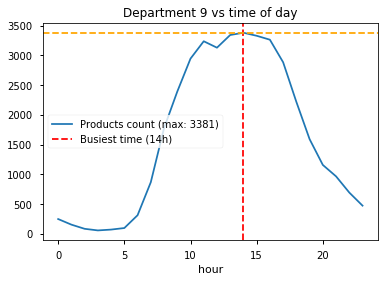

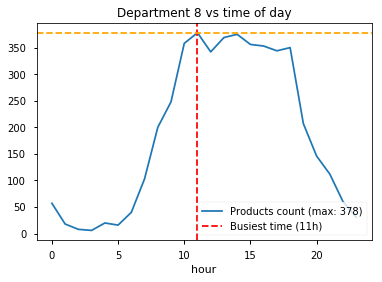

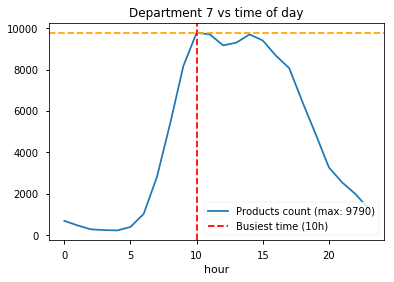

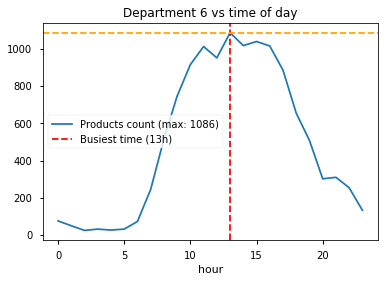

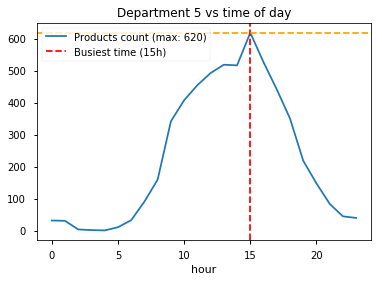

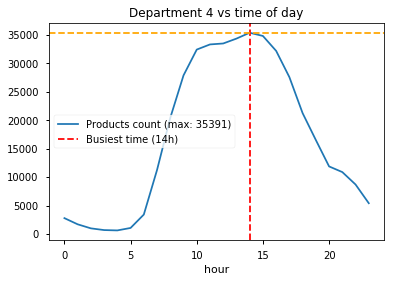

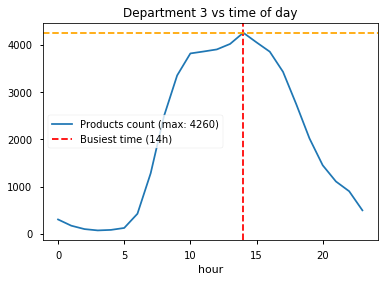

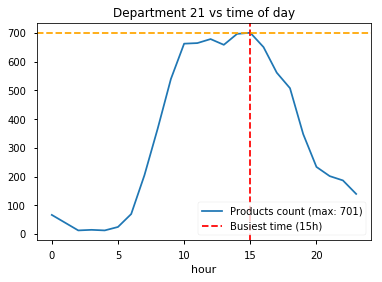

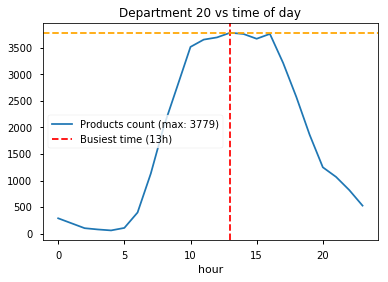

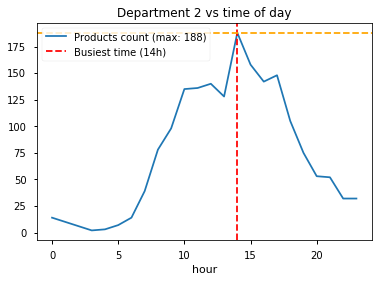

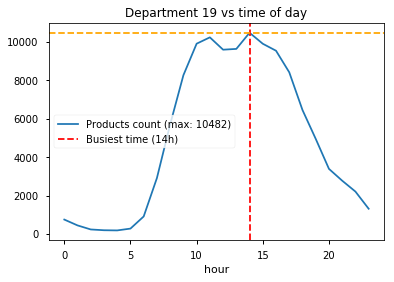

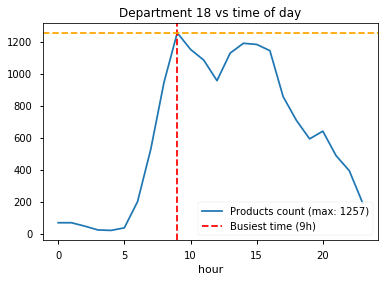

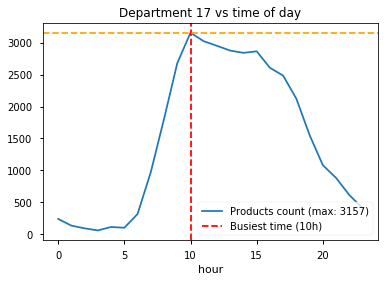

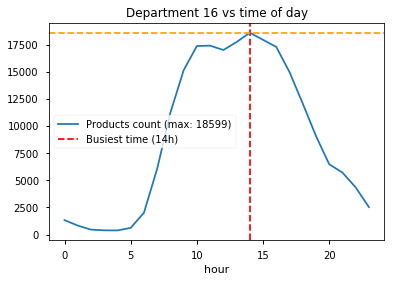

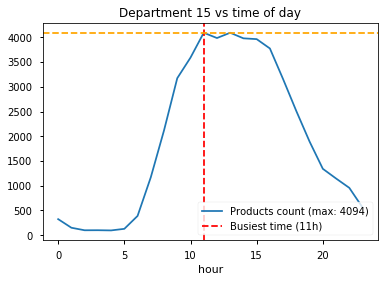

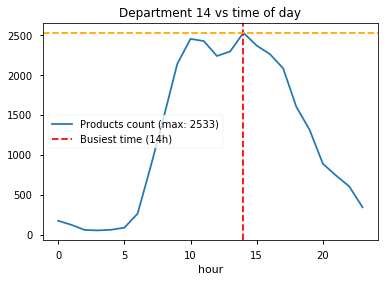

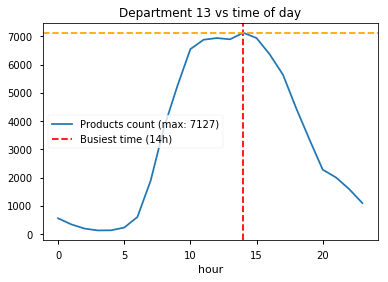

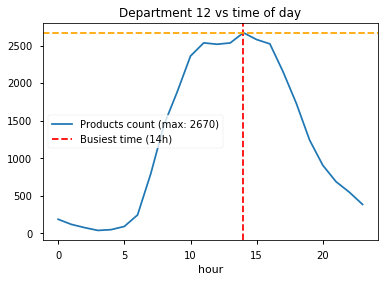

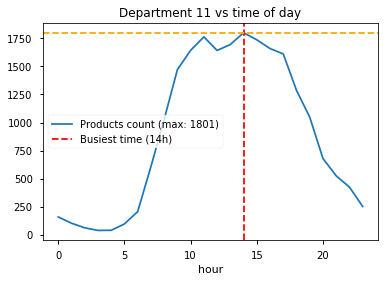

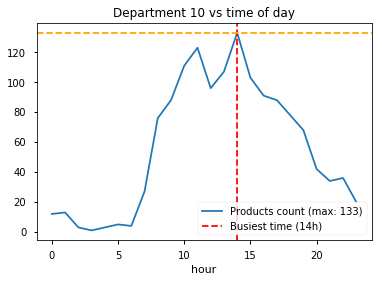

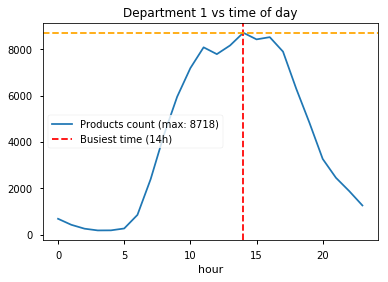

In [39]:
for i, d in enumerate(un_depts):
    sdf.loc[d].plot(x='hour',y='product_count', title='Department {} vs time of day'.format(d), legend=False)
    bh = busiest_hour_df.loc[str(d), 'hour']
    plt.axvline(bh, color='red', linestyle='--')
    bh_count = busiest_hour_df.loc[str(d), 'product_count']
    plt.axhline(bh_count, color='orange', linestyle='--')
    plt.legend(['Products count (max: {})'.format(bh_count), 'Busiest time ({}h)'.format(bh)])
plt.show()

#### 3.1.1 What is the size of the orders (basket size)? 

In [40]:
basket_size_columns = ['basket_size', 'order_count']
basket_size_df = df_order_prod.groupby('order_id').count() \
                .groupby('count').count().toDF(*basket_size_columns)

In [41]:
bs_df = pd.DataFrame(basket_size_df.collect(), columns=basket_size_columns)

In [42]:
# print(plt.style.available)

<Container object of 75 artists>

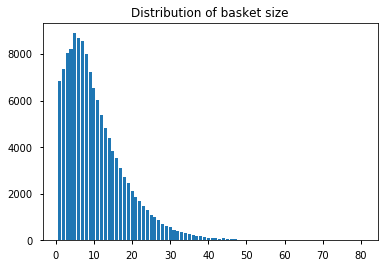

In [43]:
# plt.gca().set_xtick([i if i % 10 == 0 else "" for i in range(10)])
plt.title('Distribution of basket size')
plt.bar(x=bs_df['basket_size'].values, height=bs_df['order_count'].values)

### 3.2 Run MBA for the training set (10 points)

Using the orders from the ``order_products__train.csv``, create a data frame where each row contain just one column, the transaction, with the list of purchased products. For this task, you do not have to query for the product names to run the MBA algorithm. You can assume that the product name is its id. This can accelerate the algorithm since the product names can be quite big.

You must report the time spent to perform this task.

In [19]:
"""
TODO: create a query to create and sctruct the transactions
"""
# products_in_order = spark.sql('SELECT op.order_id, COLLECT_LIST(op.product_id) AS transaction' 
#                ' FROM order_prod op'
#                ' GROUP BY op.order_id')
# products_in_order.show(5, truncate=80)

'\nTODO: create a query to create and sctruct the transactions\n'

In [46]:
# def concat_row_to_mba(row):
#     return ';'.join(map(str,row))
# p_in_order = products_in_order.rdd.mapValues(concat_row_to_mba)

In [13]:
from pyspark.sql.functions import collect_list
# It is important the we set the alias `transaction` for our split to occur
# We don't split
trans_df = df_order_prod.groupBy('order_id').agg(collect_list('product_id').alias('transaction'))

In [70]:
DO_SAMPLE = True
if DO_SAMPLE:
    small_sample_rate = .0025
    sampled_trans_df_joined = trans_df.sample(small_sample_rate)
    print(sampled_trans_df_joined.count())
    sampled_trans_df_joined.collect()

327


In [14]:
def mba(dataframe, split=True, show=False):
    """
    """
    dataframe_patterns_rdd = dataframe.rdd.flatMap(map_to_patterns if split else map_to_patterns_no_split)
    if show:
        dataframe_patterns_rdd.map(format_tuples).toDF(['patterns', 'occurrences']).show(10, truncate=80)
    # ======
    dataframe_combined_patterns_rdd = dataframe_patterns_rdd.reduceByKey(reduce_patterns)
    if show:
        dataframe_combined_patterns_rdd.map(format_tuples).toDF(['patterns', 'combined_occurrences']).show(10, truncate=80)
    # =====
    dataframe_subpatterns_rdd = dataframe_combined_patterns_rdd.flatMap(map_to_subpatterns)
    if show:
        dataframe_subpatterns_rdd.map(format_tuples).toDF(['subpatterns', 'rules']).show(10, truncate=80)
    # ====
    dataframe_combined_rules = dataframe_subpatterns_rdd.groupByKey().mapValues(lambda r: tuple(r))
    if show:
        dataframe_combined_rules.map(format_tuples).toDF(['subpatterns', 'combined_rules']).show(10, truncate=80)
    # ==
    dataframe_assoc_rules = dataframe_combined_rules.map(map_to_assoc_rules)
    if show:
        dataframe_assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).show(10, truncate=80)
    return dataframe_assoc_rules

In [15]:
%%time
"""
TODO: run the MBA algorithm and show the first 5 association rules
"""
mba(sampled_trans_df_joined, show=True, split=False)

# # TODO: Replace with non sampled
# insta_patterns_rdd = sampled_trans_df_joined.rdd.flatMap(map_to_patterns)
# insta_patterns_rdd.map(format_tuples).toDF(['patterns', 'occurrences']).show(10, truncate=80)
# # ======
# insta_combined_patterns_rdd = insta_patterns_rdd.reduceByKey(reduce_patterns)
# insta_combined_patterns_rdd.map(format_tuples).toDF(['patterns', 'combined_occurrences']).show(10, truncate=80)
# # =====
# insta_subpatterns_rdd = insta_combined_patterns_rdd.flatMap(map_to_subpatterns)
# insta_subpatterns_rdd.map(format_tuples).toDF(['subpatterns', 'rules']).show(10, truncate=80)
# # ====
# insta_combined_rules = insta_subpatterns_rdd.groupByKey().mapValues(lambda r: tuple(r))
# insta_combined_rules.map(format_tuples).toDF(['subpatterns', 'combined_rules']).show(10, truncate=80)
# # ==
# insta_assoc_rules = insta_combined_rules.map(map_to_assoc_rules)
# insta_assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).show(10, truncate=80)

+------------------+-----------+
|          patterns|occurrences|
+------------------+-----------+
|        ('13176',)|          1|
|        ('30827',)|          1|
|        ('14966',)|          1|
|        ('21137',)|          1|
|        ('46129',)|          1|
|         ('3798',)|          1|
|        ('33081',)|          1|
|         ('7862',)|          1|
|('13176', '30827')|          1|
|('13176', '14966')|          1|
+------------------+-----------+
only showing top 10 rows

+---------------------------+--------------------+
|                   patterns|combined_occurrences|
+---------------------------+--------------------+
|                 ('27681',)|                  71|
|         ('44008', '46473')|                   1|
|          ('48246', '9130')|                   1|
|('17203', '44116', '48823')|                   1|
|('12986', '40310', '44008')|                   1|
|('31215', '32520', '48823')|                   1|
| ('17758', '48823', '5194')|                   1|
|(

The execution time was 11min34s as you can see above.

## 3.3 Run MBA for your custom dataset (25 points)

As you probably noticed, even for a not so large data set (the training file has only 131209 orders), the MBA algorithm is computationally expensive. For that reason, this time, we will repeat the process, but now using the Google Cloud Platform (GCP) to create a large computer cluster. All the instructions for creating a computing cluster with spark and how to submit a job will be explained in both sessions of the laboratory. In any case, you should read the instructions given in the ``instruction_gcp.pdf``.

This time, we will work with the ``order_products__prior.csv`` file, which contains more than 3M orders.

Machines used to run the application:
- Master Node: 1 x `n1-highmem-32`
- Worker Nodes: 6 x `n1-highmem-64`

**EXPECTED OUTPUT**

After you ran the MBA for the larger collection of orders, randomly select 10 products purchased in ``order_products__prior`` and print the association rules associated to those products when the product is alone in the basket. **This time,  the products' name should be printed, not its ID. You can still perform the MBA using the IDs, but this last print must show the names. **  
       
Report the execution time.

In [ ]:
"""
TODO: create a query to create and sctruct the transactions from the order_products__prior.csv file
"""
if GPC:
    _df_prior = spark.read.csv(INSTA_ORDER_PRODUCTS_PRIOR_PATH, header=True, sep=',', inferSchema=True)
else:
    pass
    _df = pd.read_csv(INSTA_ORDER_PRODUCTS_PRIOR_PATH, header=0, sep=',', nrows=1000)
    _df_prior = spark.createDataFrame(_df)
print('order_products__prior.csv')
# df_order_prod_prior.show(5)

order_products__prior.csv


In [ ]:
%%time
"""
TODO: run the MBA algorithm and print the requested output
"""
from pyspark.sql.functions import collect_list, col
# It is important the we set the alias `transaction` for our split to occur
df_collected_prior = (_df_prior.join(df_products, on='product_id')).groupBy('order_id').agg(collect_list('product_name').alias('transaction'))
df_collected_joined_prior = df_collected_prior
df_prior_assoc_rules = mba(df_collected_joined_prior, show=True, split=False)

+-------------------------------------+-----------+
|                             patterns|occurrences|
+-------------------------------------+-----------+
|            (u'Organic Red Lentils',)|          1|
|           (u'Organic Coconut Milk',)|          1|
|(u'Organic Unsweetened Almond Milk',)|          1|
|                      (u'Goat Milk',)|          1|
|     (u'Cage Free Large White Eggs',)|          1|
|  (u'Organic Large Green Asparagus',)|          1|
|                    (u'Sweet Onion',)|          1|
|           (u'Organic Baby Spinach',)|          1|
|     (u'Organic Yukon Select Fries',)|          1|
|           (u'Avocado Oil, Refined',)|          1|
+-------------------------------------+-----------+
only showing top 10 rows

+--------------------------------------------------------------------------------+--------------------+
|                                                                        patterns|combined_occurrences|
+-------------------------------------

**We ran out of Google Cloud credits after having run the algorithm twice without float values, which caused our division to be equal to zero. We have here the output from those runs. The incomplete output above is from when we ran out of credits.**

The three times we were able to run the code, our run times were 50, 54, and 58 minutes.

``` +--------+-----------+
|patterns|occurrences|
+--------+-----------+
|(38650,)|          1|
|(25659,)|          1|
|(35951,)|          1|
|(34197,)|          1|
|(11712,)|          1|
|(26940,)|          1|
|(48364,)|          1|
|(21903,)|          1|
|(14881,)|          1|
|(34720,)|          1|
+--------+-----------+
only showing top 10 rows

+---------------------+--------------------+
|             patterns|combined_occurrences|
+---------------------+--------------------+
| (7628, 23291, 27156)|                   1|
|   (1511, 1848, 4118)|                   1|
|(14947, 38164, 49374)|                   1|
| (8277, 25783, 48705)|                   2|
|  (7041, 7493, 34243)|                   1|
|(14063, 23888, 47766)|                   1|
|(13077, 38015, 44449)|                   1|
| (9510, 18721, 33168)|                   1|
|(11109, 35973, 44375)|                   1|
|(13336, 43230, 49683)|                   1|
+---------------------+--------------------+
only showing top 10 rows

+---------------------+----------+
|          subpatterns|     rules|
+---------------------+----------+
|(18850, 26669, 40144)| (None, 5)|
|       (26669, 40144)|(18850, 5)|
|       (18850, 40144)|(26669, 5)|
|       (18850, 26669)|(40144, 5)|
|(19963, 26604, 32534)| (None, 1)|
|       (26604, 32534)|(19963, 1)|
|       (19963, 32534)|(26604, 1)|
|       (19963, 26604)|(32534, 1)|
| (4987, 23054, 35628)| (None, 1)|
|       (23054, 35628)| (4987, 1)|
+---------------------+----------+
only showing top 10 rows

+---------------------+--------------------------------------------------------------------------------+
|          subpatterns|                                                                  combined_rules|
+---------------------+--------------------------------------------------------------------------------+
| (9507, 12732, 41950)|                                                                    ((None, 1),)|
|       (20876, 38370)|((33210, 1), (13654, 1), (25985, 1), (4103, 1), (18747, 1), (23687, 1), (None...|
| (9216, 36728, 38377)|                                                                    ((None, 1),)|
| (8986, 28348, 30391)|                                                                    ((None, 1),)|
|(22247, 43524, 44538)|                                                                    ((None, 1),)|
| (5785, 16384, 44632)|                                                                    ((None, 3),)|
|(21288, 29867, 45104)|                                                                    ((None, 1),)|
|(18918, 21946, 42585)|                                                                    ((None, 1),)|
|(22935, 33055, 37807)|                                                                    ((None, 3),)|
| (5757, 14917, 47087)|                                                                    ((None, 4),)|
+---------------------+--------------------------------------------------------------------------------+
only showing top 10 rows

+---------------------+--------------------------------------------------------------------------------+
|             patterns|                                                               association_rules|
+---------------------+--------------------------------------------------------------------------------+
|(14651, 28058, 36256)|                                                                              []|
|(19749, 22922, 41006)|                                                                              []|
|(18259, 20995, 31343)|                                                                              []|
|(17526, 21137, 37464)|                                                                              []|
|(23919, 28123, 48179)|                                                                              []|
|(20119, 26620, 39578)|                                                                              []|
| (9098, 29240, 32299)|                                                                              []|
|(14218, 22034, 49381)|                                                                              []|
| (4920, 22935, 39924)|                                                                              []|
|       (13621, 21417)|[(30169, 0), (48775, 0), (18502, 0), (40501, 0), (45, 0), (31391, 0), (27086,...|
+---------------------+--------------------------------------------------------------------------------+
only showing top 10 rows

CPU times: user 544 ms, sys: 176 ms, total: 720 ms
Wall time: 50min 29s
```


For printing the names we choose to iteratively lookup the keys in the sqlContext. While this is not a parallel execution, it is good enough since we want only 10 items. 
If we would want a more efficient version we could join use the `product_name` as the input of the algorithm but if two products have the same id, the results would be erroneous.

**After making corrections to our code, we were unable to run the algorithm again because we ran out of GCP credits. However, the code is functional and would give the correct results if it was run.**

With the pre-join method:

In [ ]:
# %%time
# # Ex: Running with the product names:
# from pyspark.sql.functions import collect_list, col, array_join
# a = (_df_prior.join(df_products, on='product_id')).groupBy('order_id')\
#     .agg(collect_list('product_name').alias('transaction'))
# b = mba(a, show=False, split=False)

In [ ]:
%%time
sample = df_prior_assoc_rules.filter(lambda kv: len(kv[0]) ==1).takeSample(num=10, withReplacement=False)


In [ ]:
for s in sample:
    product_name = s[0][0]
    associations = s[1][:3]

    line = product_name + ": " + str(associations)
    print(line)

In [ ]:
# print(sample[5][1])
[max(s[1], key=lambda a: a[1]) for s in sample]

With the iterative method:

In [ ]:
# %%time
# initial_results = df_prior_assoc_rules.filter(lambda kv: len(kv[0]) ==1).map(lambda kv: (int(kv[0][0]), kv[1])) \
#                     .join(df_products.select('product_id','product_name').rdd)\
#                     .map(lambda kv: (kv[1][1], kv[1][0]) )\
#                     .takeSample(num=10, withReplacement=False)

# for samples in initial_results:
#     product_id, associations = samples
#     association_with_names = []
#     for product, prob in associations:
#         name = df_products.filter(df_products.product_id == product).first().asDict()['product_name']
#         association_with_names.append((name, prob))
#     print(product_id, association_with_names)